## Business Problem : 
<br>
<li> Evaluate the effectiveness of a promotional campaign aimed at increasing sales of a specific product category.
<li> To understand the incremental uplift of the promotion and determine whether "Buy One Get One" or “Discount" generate a higher uplift in sales.    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import chi2
import sklearn
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklift.metrics import uplift_at_k, uplift_by_percentile, weighted_average_uplift, qini_auc_score, uplift_auc_score
from sklift.models import TwoModels
from sklift.viz import plot_uplift_by_percentile, plot_uplift_preds, plot_qini_curve, plot_uplift_curve

import warnings
warnings.filterwarnings("ignore")

sns.set(style = 'darkgrid', rc = {'figure.figsize':(12,4)})
colors = sns.color_palette('colorblind')[0:5]

#### Data Description :
- <b>`recency`</b> - Months since last purchase <br>
- <b>`historical customer spend`</b> - $total historical spend of the customer <br>
- <b>`has_used_discount_in_the_past`</b> - Indicates if the customer used a discount before in the past <br>
- <b>`has_used_bogo_in_the_past`</b> - Indicates if the customer used a buy one get one before in the past <br>
- <b>`Urbanity`</b> - Urbanity of the customer : <i>Suburban/Urban/Rural <br>
- <b>`is_referral`</b> - Indicates if the customer was acquired from referral channel <br>
- <b>`channel`</b> - Channels that the customer using : <i>store/Web/Multichannel <br>
- <b>`offer`</b> - The offer sent to the customers : <i> Discount/Buy One Get One/No Offer <br>
- <b>`conversion`</b> - Customer conversion (bought or not) <br><br>

For the analysis of `incremental uplift modeling`, we can describe `Treatment` and `Target` columns as below. 
- <b>`Treatment Variable`</b> - Offer <br>
- <b>`Target Variable`</b> - Conversion (Purchase or No Purchase)

# Understanding the DATA - `EDA`

In [234]:
df = pd.read_excel('Case Dataset.xlsx')

In [235]:
df.head()

,CustomerID,recency,historical customer spend,has_used_discount_in_the_past,has_used_bogo_in_the_past,Urbanity,is_referral,channel,offer,conversion
0,1,10,142.440,1,0,Surburban,0,store,Buy One Get One,0
1,2,6,329.080,1,1,Rural,1,Web,No Offer,0
2,3,7,180.650,0,1,Surburban,1,Web,Buy One Get One,0
3,4,9,675.830,1,0,Rural,1,Web,Discount,0
4,5,2,45.340,1,0,Urban,0,Web,Buy One Get One,0


In [236]:
df.drop('CustomerID', axis = 1, inplace = True)

In [237]:
# Checking for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   recency                        64000 non-null  int64  
 1   historical customer spend      64000 non-null  float64
 2   has_used_discount_in_the_past  64000 non-null  int64  
 3   has_used_bogo_in_the_past      64000 non-null  int64  
 4   Urbanity                       64000 non-null  object 
 5   is_referral                    64000 non-null  int64  
 6   channel                        64000 non-null  object 
 7   offer                          64000 non-null  object 
 8   conversion                     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [238]:
df.describe()

,recency,historical customer spend,has_used_discount_in_the_past,has_used_bogo_in_the_past,is_referral,conversion
count,"64,000.000","64,000.000","64,000.000","64,000.000","64,000.000","64,000.000"
mean,5.764,242.086,0.551,0.550,0.502,0.147
std,3.508,256.159,0.497,0.498,0.500,0.354
min,1.000,29.990,0.000,0.000,0.000,0.000
25%,2.000,64.660,0.000,0.000,0.000,0.000
50%,6.000,158.110,1.000,1.000,1.000,0.000
75%,9.000,325.657,1.000,1.000,1.000,0.000
max,12.000,"3,345.930",1.000,1.000,1.000,1.000


In [239]:
df.describe(include = object)

,Urbanity,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


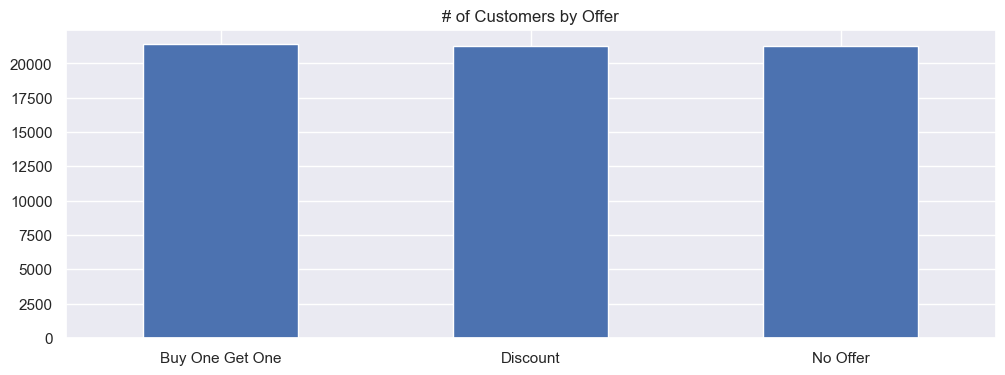

In [240]:
df['offer'].value_counts().plot(kind = 'bar', grid = 'True')
plt.xticks(rotation=0)
plt.title('# of Customers by Offer')
plt.show()

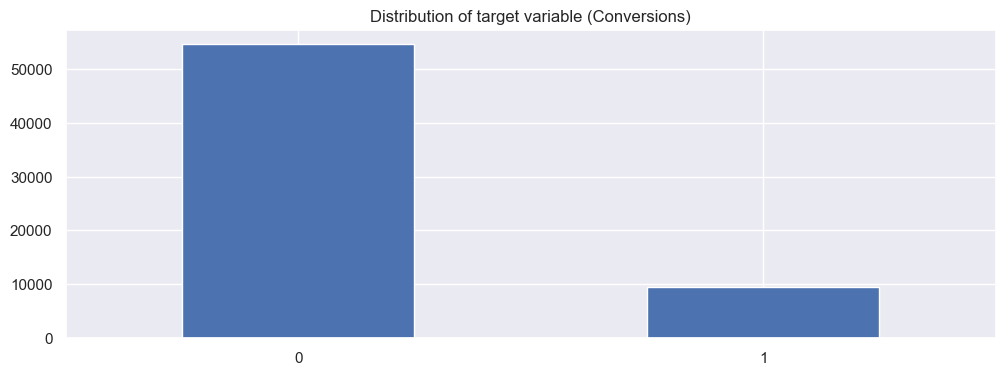

In [241]:
df['conversion'].value_counts().plot(kind = 'bar', grid = 'True')
plt.xticks(rotation=0)
plt.title('Distribution of target variable (Conversions)')
plt.show()

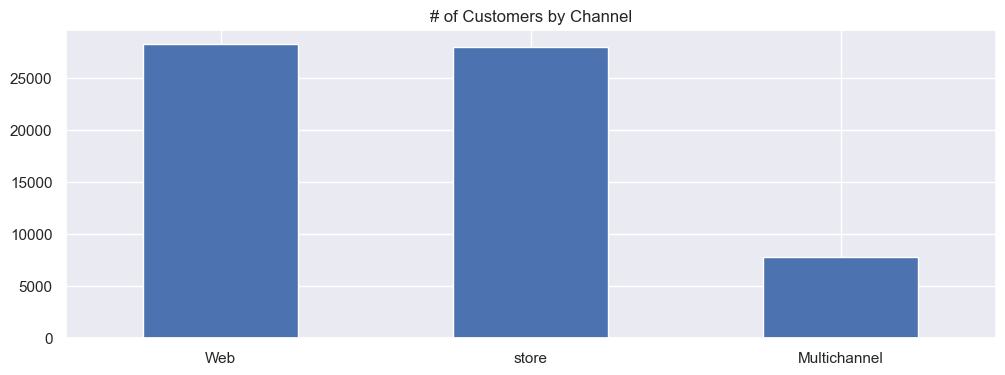

In [242]:
df['channel'].value_counts().plot(kind = 'bar', grid = 'True')
plt.xticks(rotation=0)
plt.title('# of Customers by Channel')
plt.show()

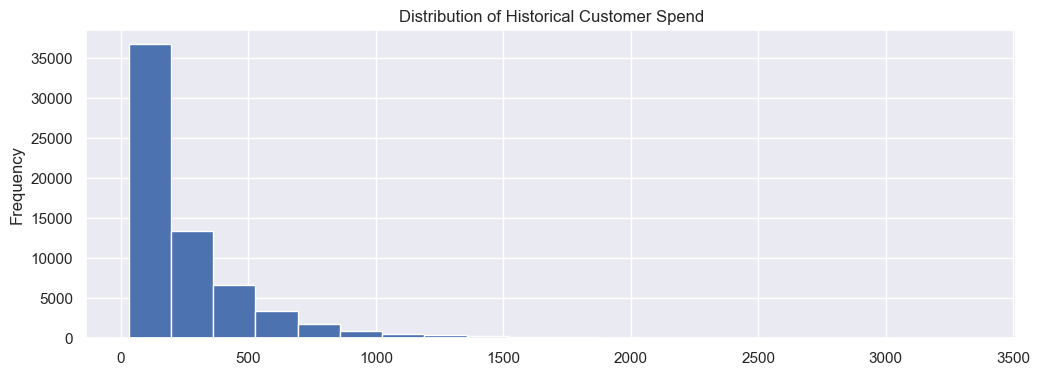

In [243]:
df['historical customer spend'].hist(bins=20, grid=True);
plt.title('Distribution of Historical Customer Spend')
plt.ylabel('Frequency')
plt.show()

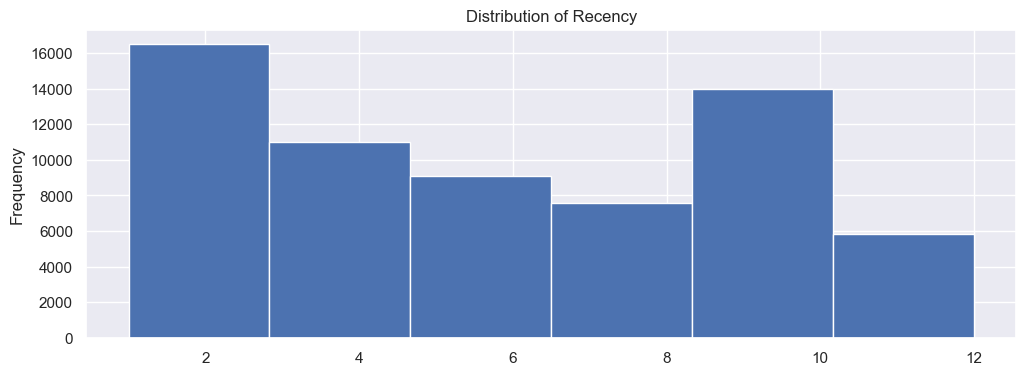

In [244]:
df['recency'].hist(grid=True, bins=6);
plt.title('Distribution of Recency')
plt.ylabel('Frequency')
plt.show()

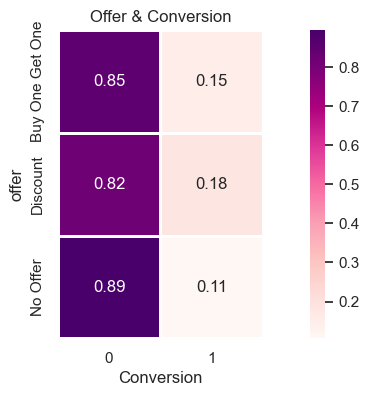

In [245]:
crosstab = pd.crosstab(df.offer, df.conversion, normalize='index')
sns.heatmap(crosstab, annot=True, fmt=".2f", linewidths=1, square = True, cmap = 'RdPu')
plt.xlabel('Conversion')
plt.title("Offer & Conversion")
plt.show()

## Incremental Uplift Modeling for BOGO

In [246]:
# Creating a data frame with Treatment group(Offer = Buy One Get One) and Control group(Offer = No Offer)

df_BOGO = df[df['offer'] != 'Discount']

treatment_BOGO_dict = {
            'Buy One Get One': 1,
            'No Offer': 0
            }
df_BOGO['treatment_BOGO'] = df_BOGO['offer'].map(treatment_BOGO_dict)
df_BOGO.drop(['offer'], axis=1, inplace = True)

In [247]:
df_BOGO.shape

(42693, 9)

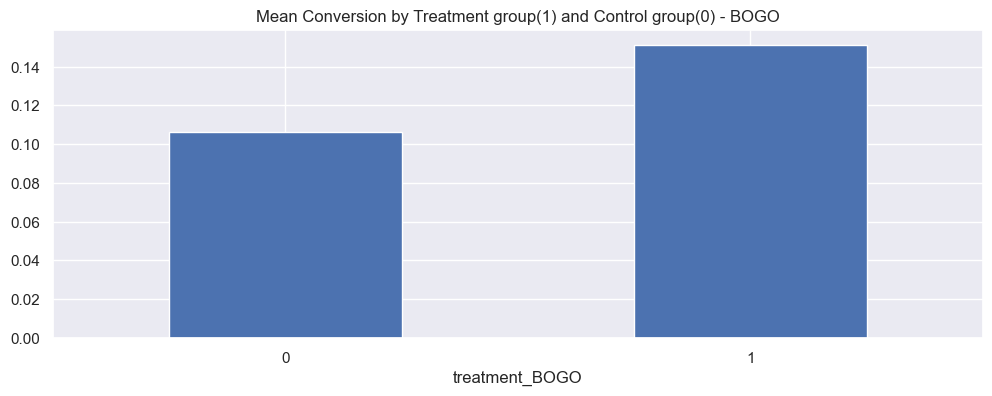

In [248]:
df_BOGO.groupby(df_BOGO['treatment_BOGO'])['conversion'].mean().plot(kind = 'bar', grid = 'True')
plt.title('Mean Conversion by Treatment group(1) and Control group(0) - BOGO')
plt.xticks(rotation=0)
plt.show()

### `Chi-Square Test of Independence`

<b>Aim : </b>
Decide if buyers' decision of purchase (conversion) is related to the treatment (BOGO and No offer).

In [249]:
BOGO_converted = df_BOGO[(df_BOGO['treatment_BOGO'] == 1) & (df_BOGO['conversion'] == 1)]['treatment_BOGO'].value_counts().values[0]
BOGO_nonconverted = df_BOGO[(df_BOGO['treatment_BOGO'] == 1) & (df_BOGO['conversion'] == 0)]['treatment_BOGO'].value_counts().values[0]
no_offer_converted = df_BOGO[(df_BOGO['treatment_BOGO'] == 0) & (df_BOGO['conversion'] == 1)]['treatment_BOGO'].value_counts().values[0]
no_offer_nonconverted = df_BOGO[(df_BOGO['treatment_BOGO'] == 0) & (df_BOGO['conversion'] == 0)]['treatment_BOGO'].value_counts().values[0]

BOGO_contingency = np.array([[BOGO_converted, BOGO_nonconverted], [no_offer_converted, no_offer_nonconverted]])

# Perform the chi-squared test
chi2, p_value, dof, expected = chi2_contingency(BOGO_contingency)

# print results
print('Chi-Square Statistic:', chi2)
print('p-value:', p_value)

Chi-Square Statistic: 194.17681178126966
p-value: 3.896493359374824e-44


<b>Conclusion : </b>
Observed `P-value` of Chi-square test is significantly `lower than` the threshold value `0.05` which concludes that the buyers' decision of `purchase (Conversion)` is `related to the treatment (BOGO and No offer)`.

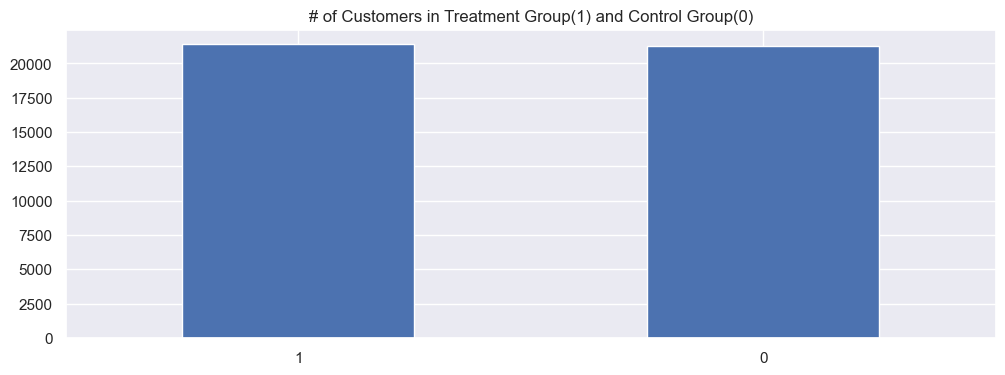

In [250]:
df_BOGO['treatment_BOGO'].value_counts().plot(kind = 'bar', grid = 'True')
plt.title('# of Customers in Treatment Group(1) and Control Group(0)')
plt.xticks(rotation=0)
plt.show()

In [251]:
# list of feature columns: excluding the target columns
features = np.setdiff1d(df_BOGO.columns, ["conversion", "treatment_BOGO"] ).tolist()
BOGO_X = df_BOGO[features]
BOGO_X.head()

,Urbanity,channel,has_used_bogo_in_the_past,has_used_discount_in_the_past,historical customer spend,is_referral,recency
0,Surburban,store,0,1,142.440,0,10
1,Rural,Web,1,1,329.080,1,6
2,Surburban,Web,1,0,180.650,1,7
4,Urban,Web,0,1,45.340,0,2
5,Surburban,store,1,0,134.830,0,6


In [252]:
BOGO_treat = df_BOGO['treatment_BOGO']
BOGO_y = df_BOGO['conversion']

In [253]:
stratify_cols = pd.concat([df_BOGO.treatment_BOGO, df_BOGO.conversion], axis=1)

In [254]:
X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(
    df_BOGO.drop(['treatment_BOGO','conversion'],axis=1), BOGO_treat,BOGO_y,
    stratify=stratify_cols, test_size=0.3, random_state=42)

In [255]:
# categorical features
catfeat = ['Urbanity', 'channel', 'has_used_bogo_in_the_past', 'has_used_discount_in_the_past', 'is_referral']

### `Two Independent Models`

In [256]:
# prepare model
BOGO_estimator_2m_treat = CatBoostClassifier(iterations = 20, thread_count = 2, random_state = 42, silent = True)
BOGO_estimator_2m_control = CatBoostClassifier(iterations = 20, thread_count = 2, random_state = 42, silent = True)

BOGO_model_2im = TwoModels(estimator_trmnt = BOGO_estimator_2m_treat, estimator_ctrl = BOGO_estimator_2m_control, 
                           method = "vanilla")
BOGO_model_2im = BOGO_model_2im.fit(X_train, y_train, treat_train, 
                          estimator_trmnt_fit_params={"cat_features": catfeat}, 
                          estimator_ctrl_fit_params={"cat_features": catfeat})

In [257]:
# model results: uplift
BOGO_pred_uplift_2im = BOGO_model_2im.predict(X_test)
uplift_2im_avg = weighted_average_uplift(y_test, BOGO_pred_uplift_2im, treat_test, bins=10) 
print(f"average uplift: {uplift_2im_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(y_test, BOGO_pred_uplift_2im, treat_test, strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0457


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,637,644,0.214,0.112,0.102,0.016,0.012,0.020
10-20,636,645,0.208,0.129,0.079,0.016,0.013,0.021
20-30,656,625,0.168,0.091,0.076,0.015,0.012,0.019
30-40,641,640,0.154,0.070,0.084,0.014,0.010,0.017
40-50,663,618,0.139,0.089,0.050,0.013,0.011,0.018
50-60,640,641,0.150,0.142,0.008,0.014,0.014,0.020
60-70,640,641,0.125,0.117,0.008,0.013,0.013,0.018
70-80,630,651,0.106,0.094,0.013,0.012,0.011,0.017
80-90,655,625,0.115,0.075,0.039,0.012,0.011,0.016


### `Model Result Interpretation` : 
We can expect the `BOGO` campaign to improve conversion, as measured by purchase, by an uplift of `4.6%`.

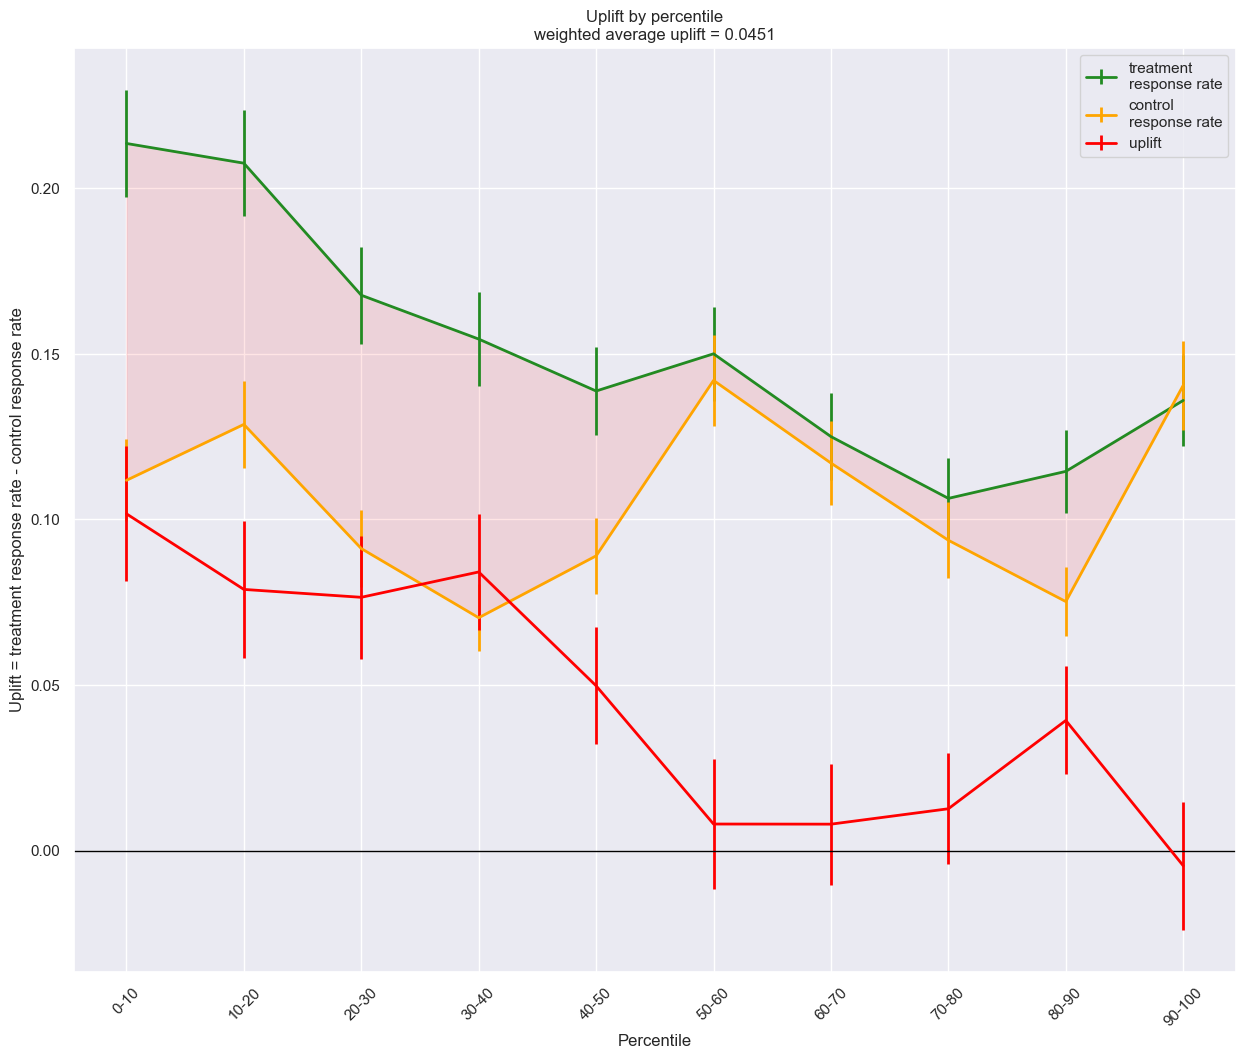

In [258]:
plot_uplift_by_percentile(y_test, BOGO_pred_uplift_2im, treat_test, strategy="overall", bins=10);
fig = plt.gcf()
fig.set_size_inches(15, 12)

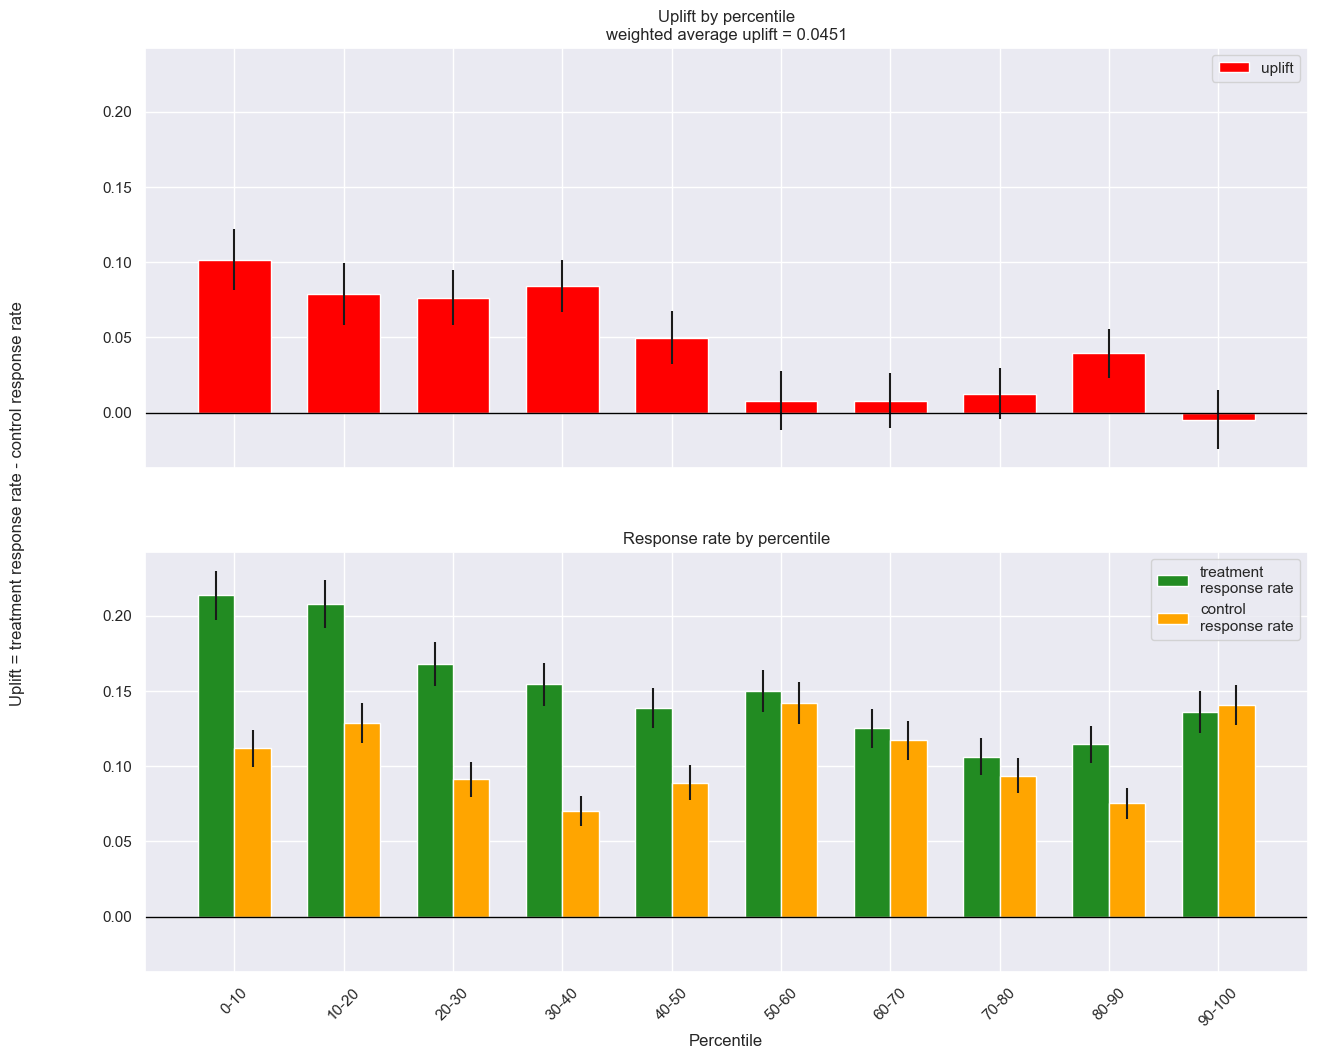

In [259]:
plot_uplift_by_percentile(y_test, BOGO_pred_uplift_2im, treat_test, strategy="overall", bins=10, kind = 'bar');
fig = plt.gcf()
fig.set_size_inches(15, 12)

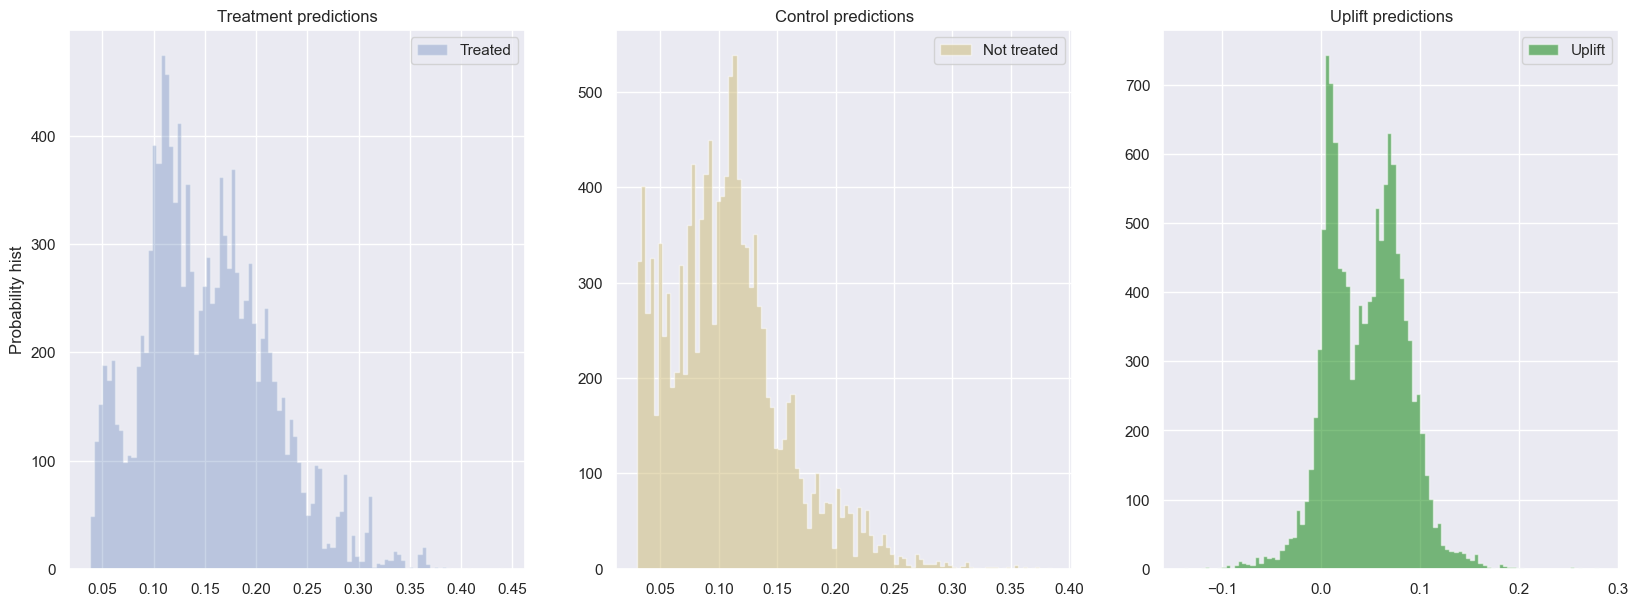

In [260]:
# probability of performing the targeted action (purchase):
prob_treat = BOGO_model_2im.trmnt_preds_         # probability in treatment group
prob_control = BOGO_model_2im.ctrl_preds_        # probability in control group
plot_uplift_preds(trmnt_preds=prob_treat, ctrl_preds=prob_control);

Qini coefficient: 0.075
Uplift auc score: 0.034


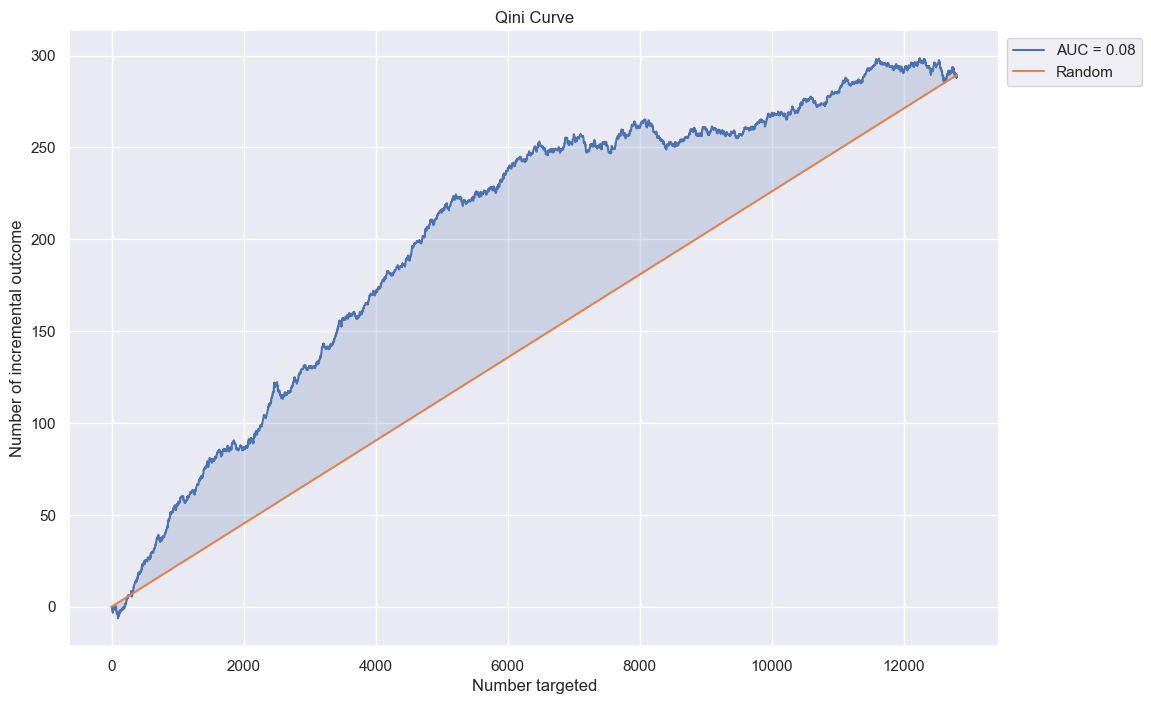

In [261]:
# AUQC = area under Qini curve
auqc = qini_auc_score(y_test, BOGO_pred_uplift_2im, treat_test) 
print(f"Qini coefficient: {auqc:.3f}")

# AUUC = area under Uplift curve
auuc = uplift_auc_score(y_test, BOGO_pred_uplift_2im, treat_test) 
print(f"Uplift auc score: {auuc:.3f}")

# qini curve
plot_qini_curve(y_test, BOGO_pred_uplift_2im, treat_test, perfect=False);
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.title('Qini Curve')
plt.show()

In [262]:
uplift_overall = uplift_at_k(y_test, BOGO_pred_uplift_2im, treat_test, strategy='overall', k=0.25)
print(f"uplift@{0.25 * 100:.0f}%: {uplift_overall:.4f}")

uplift@25%: 0.0888


## Incremental Uplift Modeling for Discount

In [263]:
# Creating a data frame with treatment group(Offer = Discount) and Control group(Offer = No Offer)

df_Discount = df[df['offer'] != 'Buy One Get One']

treatment_Discount_dict = {
            'Discount': 1,
            'No Offer': 0
            }
df_Discount['treatment_Discount'] = df_Discount['offer'].map(treatment_Discount_dict)
df_Discount.drop(['offer'],axis=1, inplace = True)

In [264]:
df_Discount.shape

(42613, 9)

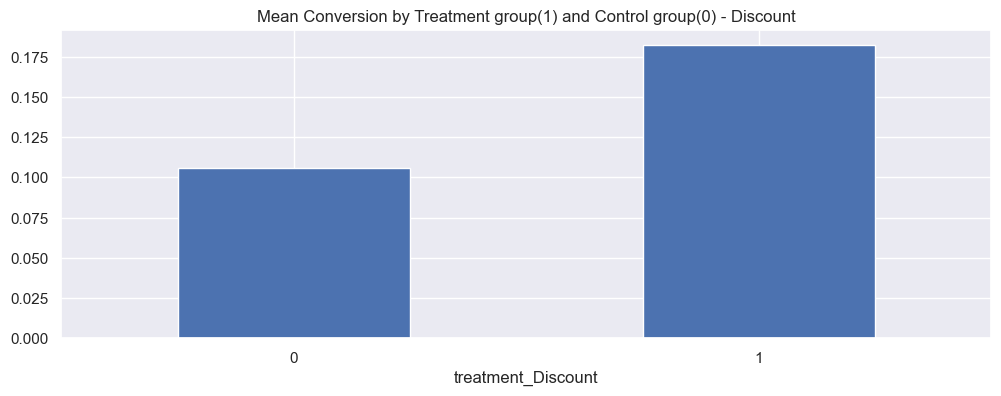

In [265]:
df_Discount.groupby(df_Discount['treatment_Discount'])['conversion'].mean().plot(kind = 'bar', grid = 'True')
plt.title('Mean Conversion by Treatment group(1) and Control group(0) - Discount')
plt.xticks(rotation=0)
plt.show()

### `Chi-Square Test of Independence`

<b>Aim : </b>
Decide if buyers' decision of purchase (conversion) is related to the treatment (Discount and No offer).

In [266]:
Discount_converted = df_Discount[(df_Discount['treatment_Discount'] == 1) & (df_Discount['conversion'] == 1)]['treatment_Discount'].value_counts().values[0]
Discount_nonconverted = df_Discount[(df_Discount['treatment_Discount'] == 1) & (df_Discount['conversion'] == 0)]['treatment_Discount'].value_counts().values[0]
no_offer_converted = df_Discount[(df_Discount['treatment_Discount'] == 0) & (df_Discount['conversion'] == 1)]['treatment_Discount'].value_counts().values[0]
no_offer_nonconverted = df_Discount[(df_Discount['treatment_Discount'] == 0) & (df_Discount['conversion'] == 0)]['treatment_Discount'].value_counts().values[0]

Discount_contingency = np.array([[Discount_converted, Discount_nonconverted], [no_offer_converted, no_offer_nonconverted]])

# Perform the chi-squared test
chi2, p_value, dof, expected = chi2_contingency(Discount_contingency)

# print results
print('Chi-Square Statistic:', chi2)
print('p-value:', p_value)

Chi-Square Statistic: 505.00253225737083
p-value: 7.754092221027678e-112


<b>Conclusion : </b>
Observed `P-value` of Chi-square test is significantly `lower than` the threshold value `0.05` which concludes that the buyers' decision of `purchase (Conversion)` is `related to the treatment (Discount and No offer)`.

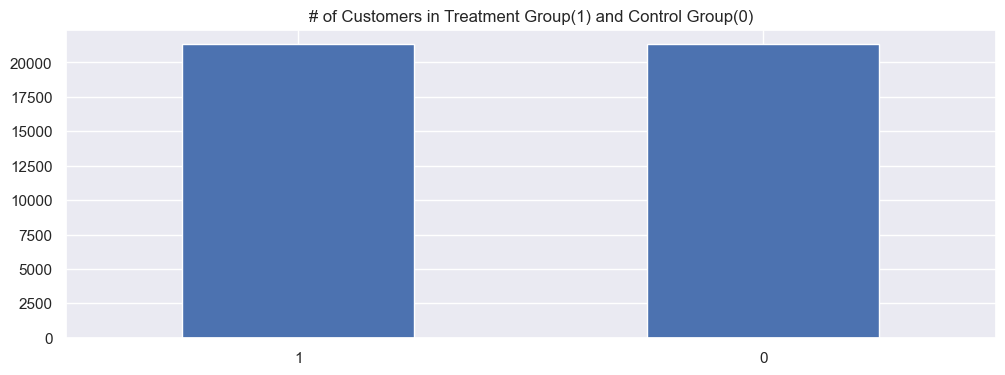

In [267]:
df_Discount['treatment_Discount'].value_counts().plot(kind = 'bar', grid = 'True')
plt.title('# of Customers in Treatment Group(1) and Control Group(0)')
plt.xticks(rotation=0)
plt.show()

In [268]:
# list of feature columns: excluding the target columns
features = np.setdiff1d(df_Discount.columns, ["conversion", "treatment_Discount"] ).tolist()
Discount_X = df_Discount[features]
Discount_X.head()

,Urbanity,channel,has_used_bogo_in_the_past,has_used_discount_in_the_past,historical customer spend,is_referral,recency
1,Rural,Web,1,1,329.080,1,6
3,Rural,Web,0,1,675.830,1,9
8,Rural,store,1,1,675.070,1,9
13,Urban,Web,1,0,101.640,0,2
14,Rural,Multichannel,1,0,241.420,1,4


In [269]:
Discount_treat = df_Discount['treatment_Discount']
Discount_y = df_Discount['conversion']

In [270]:
stratify_cols = pd.concat([df_Discount.treatment_Discount, df_Discount.conversion], axis=1)

In [271]:
Discount_X_dummy = pd.get_dummies(Discount_X)

In [272]:
X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(
    Discount_X_dummy, Discount_treat, Discount_y,
    stratify=stratify_cols, test_size=0.3, random_state=42)

### `Two Independent Models`

In [273]:
# prepare model
Discount_estimator_2m_treat = lgb.LGBMClassifier(random_state=31)
Discount_estimator_2m_control = lgb.LGBMClassifier(random_state=31)

Discount_model_2im = TwoModels(estimator_trmnt = Discount_estimator_2m_treat, estimator_ctrl = Discount_estimator_2m_control, 
                           method = "vanilla")
Discount_model_2im = Discount_model_2im.fit(X_train, y_train, treat_train)

In [274]:
# model results: uplift
Discount_pred_uplift_2im = Discount_model_2im.predict(X_test)
uplift_2im_avg = weighted_average_uplift(y_test, Discount_pred_uplift_2im, treat_test, bins=10) 
print(f"average uplift: {uplift_2im_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(y_test, Discount_pred_uplift_2im, treat_test, strategy="overall", total=True, std=True, bins=10)

uplift_by_percentile(y_test, Discount_pred_uplift_2im, treat_test, strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0761


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,640,639,0.236,0.156,0.079,0.017,0.014,0.022
10-20,653,626,0.188,0.117,0.072,0.015,0.013,0.020
20-30,670,609,0.227,0.117,0.110,0.016,0.013,0.021
30-40,633,646,0.161,0.116,0.045,0.015,0.013,0.019
40-50,624,654,0.197,0.116,0.081,0.016,0.013,0.020
50-60,613,665,0.188,0.071,0.117,0.016,0.010,0.019
60-70,632,646,0.158,0.088,0.070,0.015,0.011,0.018
70-80,643,635,0.142,0.076,0.066,0.014,0.010,0.017
80-90,627,651,0.167,0.100,0.068,0.015,0.012,0.019


### `Model Result Interpretation`
We can expect the `Discount` campaign to improve conversion, as measured by purchase, by an uplift of `7.6%`.

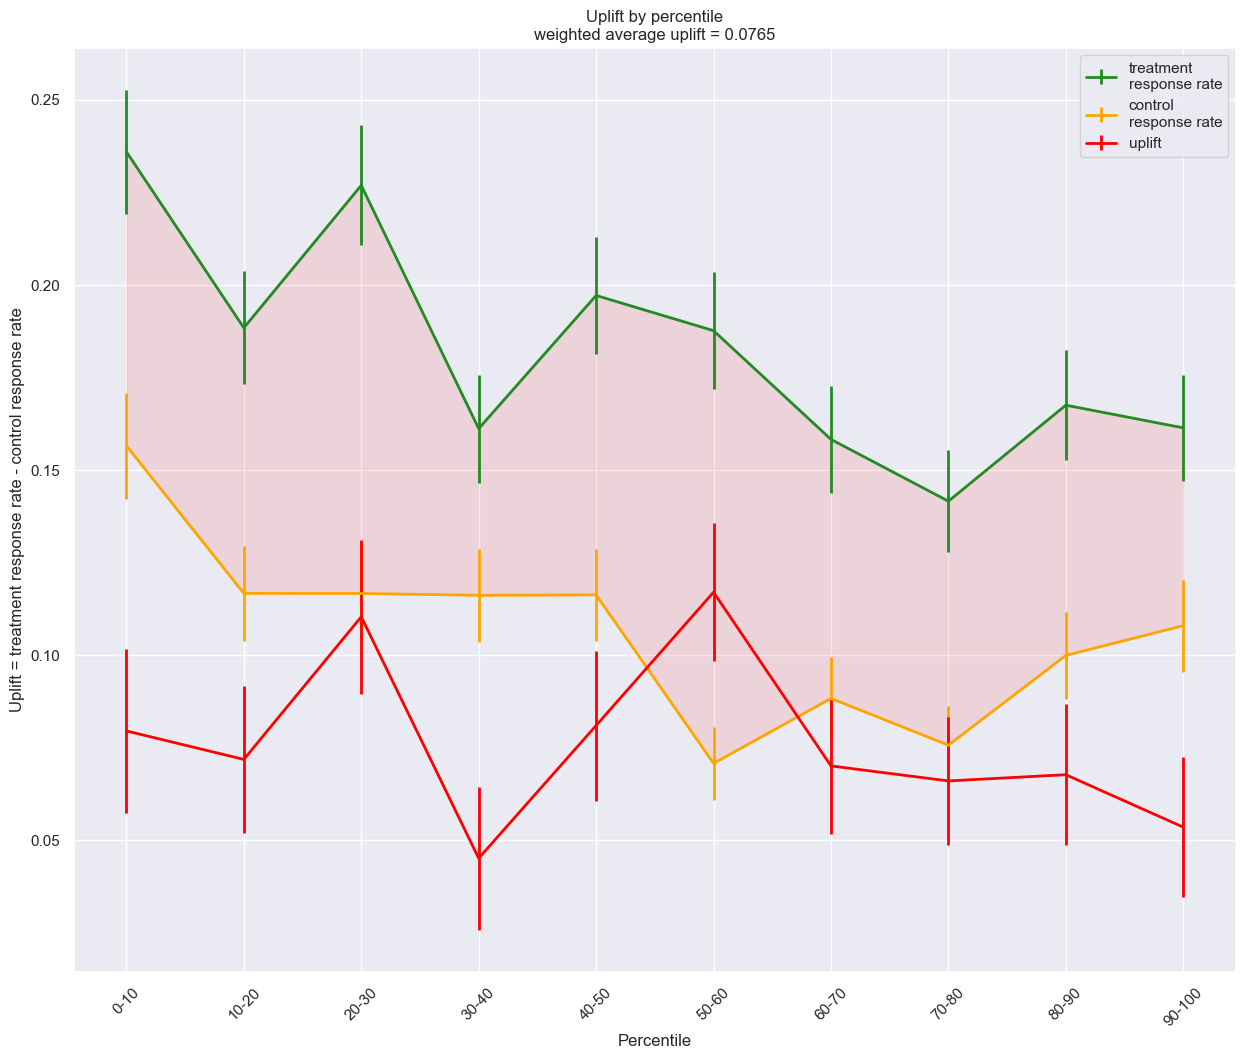

In [275]:
plot_uplift_by_percentile(y_test, Discount_pred_uplift_2im, treat_test, strategy="overall", bins=10);
fig = plt.gcf()
fig.set_size_inches(15, 12)

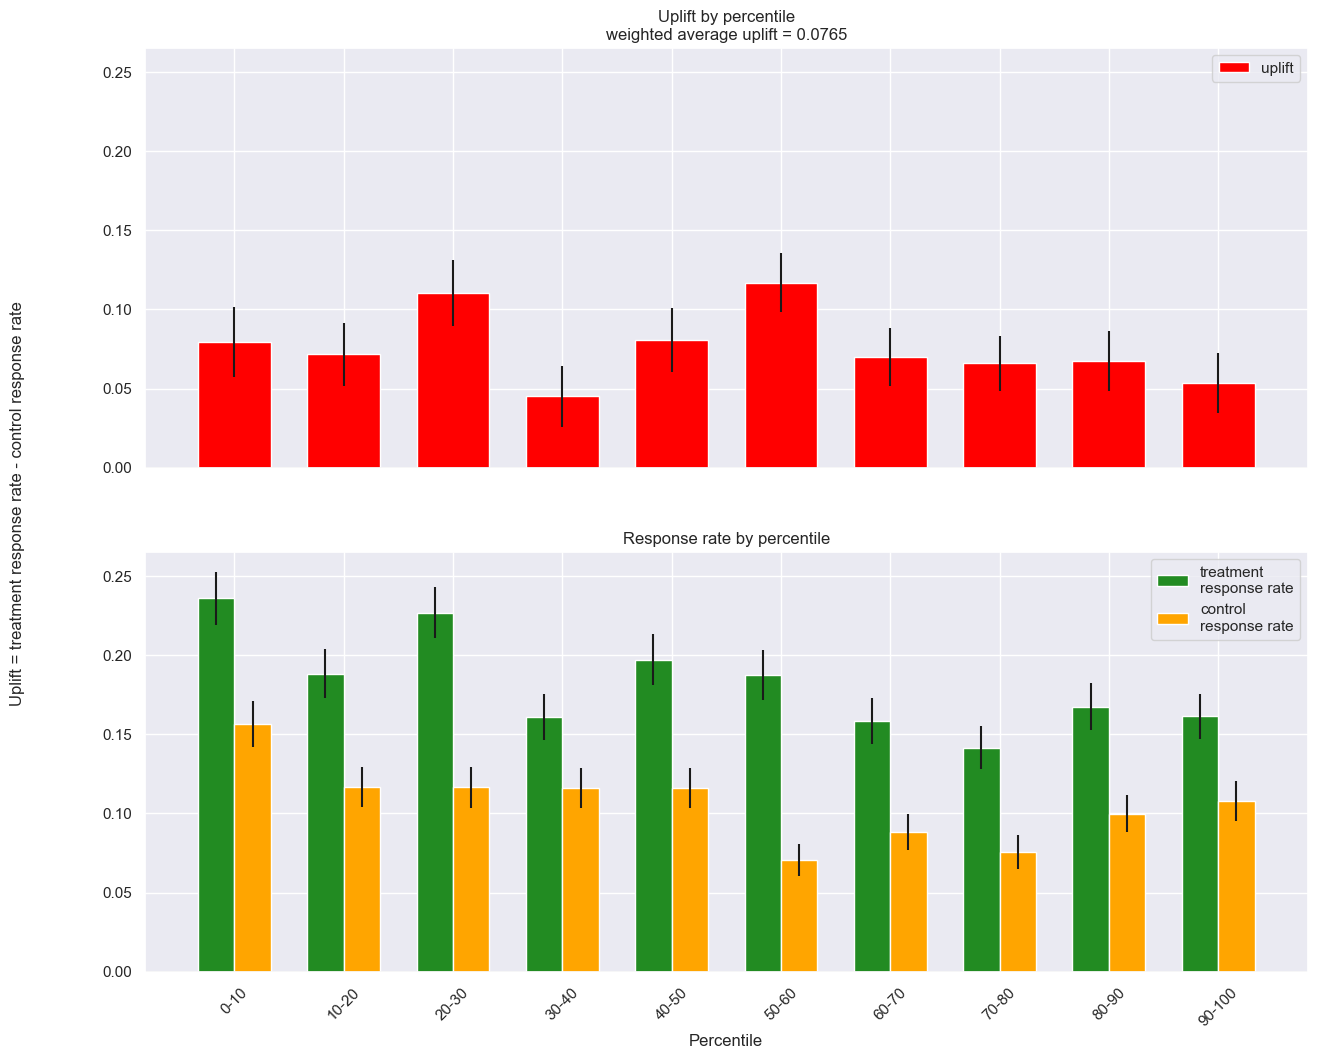

In [276]:
plot_uplift_by_percentile(y_test, Discount_pred_uplift_2im, treat_test, strategy="overall", bins=10, kind='bar');
fig = plt.gcf()
fig.set_size_inches(15, 12)

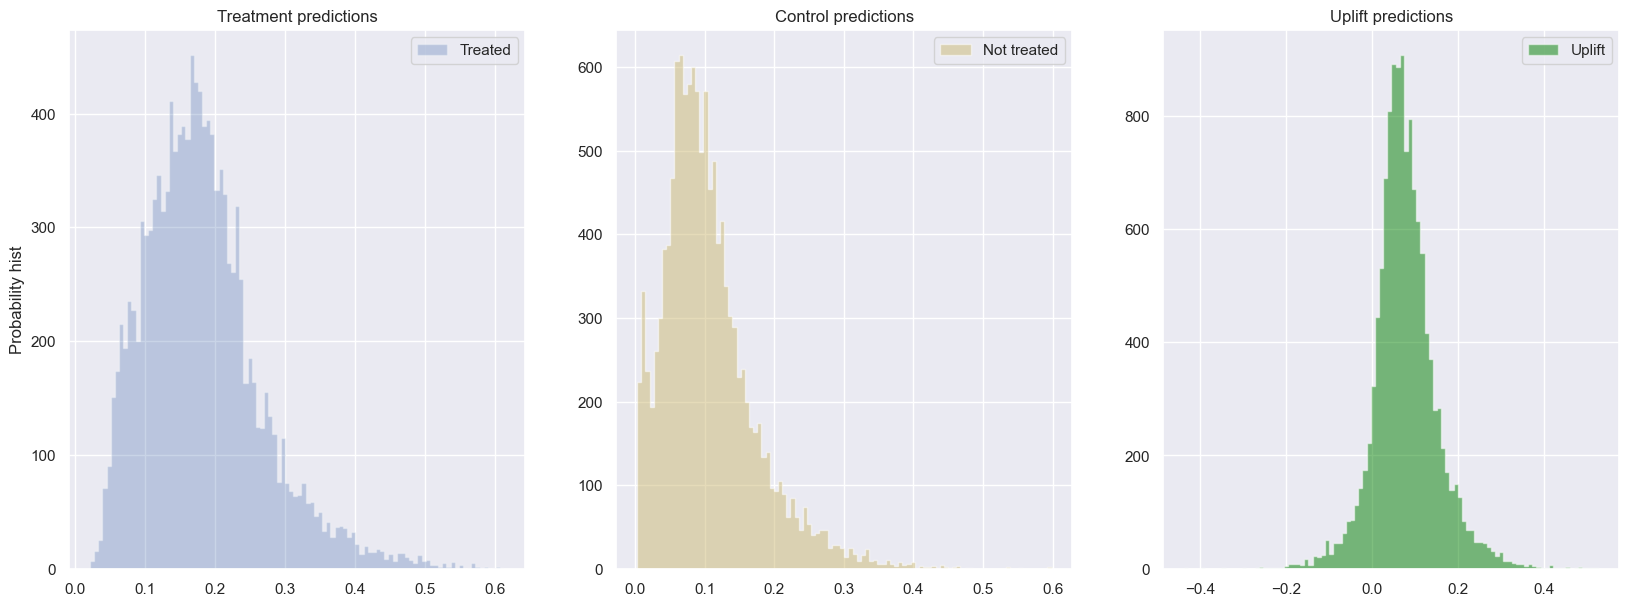

In [277]:
# probability of performing the targeted action (purchase):
prob_treat = Discount_model_2im.trmnt_preds_         # probability in treatment group
prob_control = Discount_model_2im.ctrl_preds_        # probability in control group
plot_uplift_preds(trmnt_preds=prob_treat, ctrl_preds=prob_control);

Qini coefficient: 0.013
Uplift auc score: 0.006


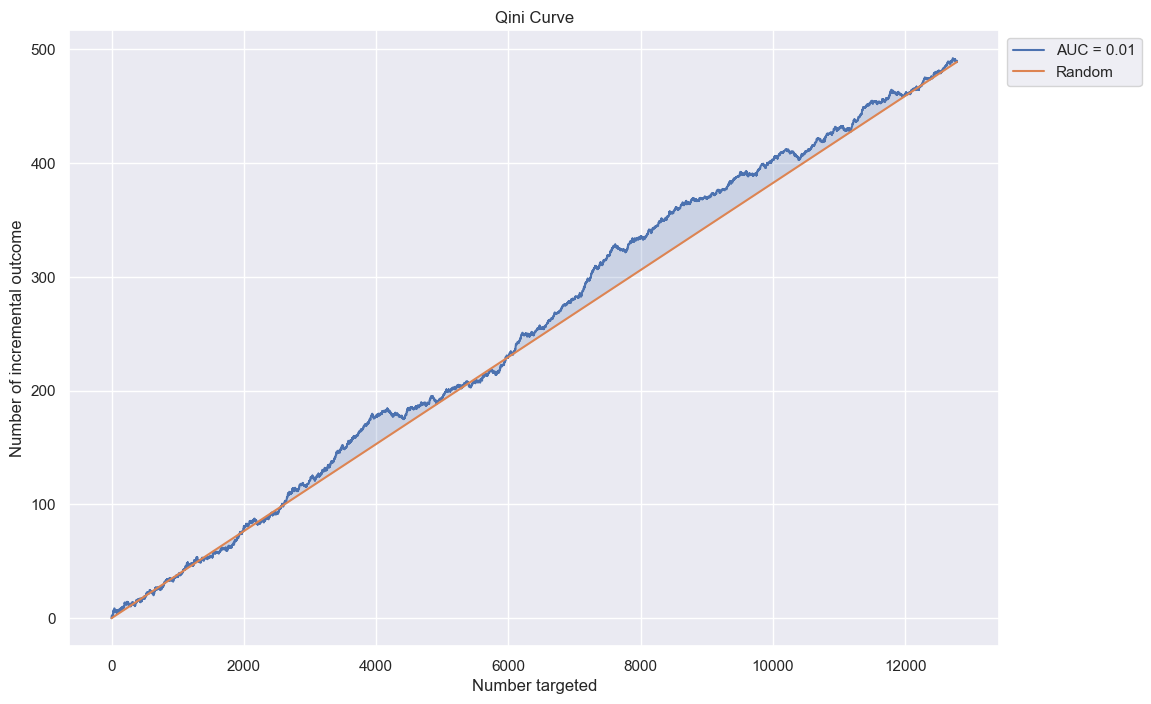

In [278]:
# AUQC = area under Qini curve
auqc = qini_auc_score(y_test, Discount_pred_uplift_2im, treat_test) 
print(f"Qini coefficient: {auqc:.3f}")

# AUUC = area under Uplift curve
auuc = uplift_auc_score(y_test, Discount_pred_uplift_2im, treat_test) 
print(f"Uplift auc score: {auuc:.3f}")

# qini curve
plot_qini_curve(y_test, Discount_pred_uplift_2im, treat_test, perfect=False);
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.savefig('qini - Discount.png')
plt.title('Qini Curve')
plt.show()

In [279]:
uplift_overall = uplift_at_k(y_test, Discount_pred_uplift_2im, treat_test, strategy='overall', k=0.25)
print(f"uplift@{0.25 * 100:.0f}%: {uplift_overall:.4f}")

uplift@25%: 0.0798


# Conclusion :

#### Weighted Average Uplift :

Buy One Get One = `4.54%` <br>
<li> On average, customers who were offered the BOGO promotion are 4.54% more likely to make a
purchase compared to customers who were not offered any promotion.

Discount = `7.61%` <br>
<li> On average, customers who were offered the Discount promotion are 7.61% more likely to make a
purchase compared to customers who were not offered any promotion. <br>
    
    
`Overall, Discount offer is more effective in increasing customer response than the BOGO offer.`<br>
`Better to opt for the offer ‘Discount’ in case company has the budget and can afford to target more customers.`


#### Uplift@25% :

Buy One Get One = `8.89%` <br>

Discount = `7.98%` <br>
        
`Indicates that the BOGO offer is more effective in increasing response rate among the top 25% of customers.`<br>
`Better to opt for the offer ‘BOGO’ in case company has limited budget and wants to achieve higher uplift in sales.`
